In [87]:
import cv2
import random
import time
import numpy as np
from scipy import misc

from matplotlib import pyplot as plt
from scipy import misc
%matplotlib inline
plt.style.use('ggplot')
import os
import sys
sys.path.append('../common/')
import utils

In [2]:
import pickle

In [3]:
import pickle
with open('./xy.pkl','rb') as whdl:
    (IM_train,y_train,IM_test) = pickle.load(whdl)

In [4]:
len(IM_train),len(y_train)

(58512, 58512)

In [5]:
?cv2.calcHist

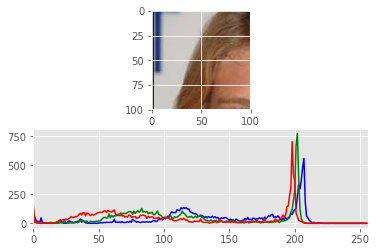

In [41]:
#histr = cv2.calcHist([IM_train[0]],[1],None,[256],[0,256])
color = ('b','g','r')
plt.subplot(2,1,1)
plt.imshow(IM_train[0])
plt.subplot(2,1,2)
for i,col in enumerate(color):
    histr = cv2.calcHist([IM_train[0]],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

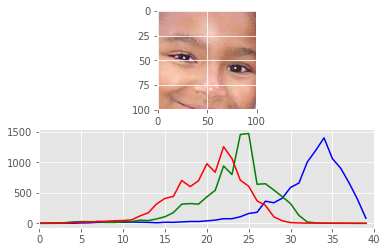

In [225]:
#histr = cv2.calcHist([IM_train[0]],[1],None,[256],[0,256])
color = ('b','g','r')
plt.subplot(2,1,1)
plt.imshow(IM_train[188])
plt.subplot(2,1,2)
for i,col in enumerate(color):
    histr = cv2.calcHist([IM_train[188]],[i],None,[40],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,40])
plt.show()

In [226]:
np.where(np.asarray(y_train)==1)[0][:10]

array([ 34,  39,  40, 145, 150, 151, 188, 192, 193, 194])

In [227]:

pb = utils.ProgressBar(worksum=len(IM_train))
pb.startjob()
features = []
targets = []
for one_image,one_target in zip(IM_train,y_train):
    one_feature = []
    if len(one_image.shape) != 3:
        continue
    for i,col in enumerate(color):
        histr = cv2.calcHist([one_image],[i],None,[40],[0,256]).T[0]
        one_feature.append(histr)
    one_feature = np.concatenate(one_feature)
    features.append(one_feature)
    targets.append(one_target)
    pb.complete(1)

 99.76 % [=================================================>-] 58371/58512 	 used:9s eta:0 s

In [228]:
len(features),len(targets)

(58371, 58371)

In [229]:
train_x,val_x = features[:-10000], features[-10000:]
train_y,val_y = targets[:-10000], targets[-10000:]

In [230]:
import sklearn
from sklearn.linear_model import LogisticRegression

In [231]:
lr = LogisticRegression()

In [232]:
lr_model = lr.fit(train_x,train_y)

In [233]:
val_pred = lr_model.predict_proba(val_x)[:,1]

In [234]:
val_pred

array([ 0.00125628,  0.00459967,  0.0254959 , ...,  0.04332959,
        0.09291954,  0.13279359])

In [235]:
from sklearn import metrics

In [236]:
 fpr, tpr, thresholds = metrics.roc_curve(val_y, val_pred, pos_label = 1)

In [237]:
metrics.auc(fpr, tpr)

0.80144708349877214

In [240]:
def get_feature(input_img):
    one_feature = []
    for i,col in enumerate(color):
        histr = cv2.calcHist([input_img],[i],None,[40],[0,256]).T[0]
        one_feature.append(histr)
    one_feature = np.concatenate(one_feature)

    return one_feature

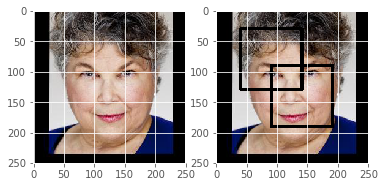

In [271]:

sample_image = np.copy(IM_test[23])
plt.subplot(1,2,1)
plt.imshow(sample_image)
for i in range(0,250 - 100,10):
    for j in range(0,250 - 100,10):
        one_feature = get_feature(sample_image[i:i + 100,j:j + 100])
        result = lr_model.predict_proba([one_feature])
        #print(result)
        if result[0][1] > 0.1:
            cv2.rectangle(sample_image,(i,j),(i + 100,j + 100),(0,0,0),3)
plt.subplot(1,2,2)
plt.imshow(sample_image)

In [249]:
result

array([[ 0.96836379,  0.03163621]])